In [1]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
pw = os.getcwd()
terminus_data_path = pw+"/../data/terminus_data/"        # folder where all the data for terminus position and terminus sections is stored
veloc_data_path    = pw+"/../data/velocity/"
weather_data_path  = pw+"/../data/weather/"
mooring_data_path  = pw+"/../data/mooring/"

In [47]:
# load datasets
df_veloc      = pd.read_csv(veloc_data_path+"velocity_by_section.csv")
df_terminus   = pd.read_csv(terminus_data_path+"retreat_by_section.csv")
# df_terminus   = pd.read_csv(terminus_data_path+"frontal_ablation.csv")
df_weather    = pd.read_csv(weather_data_path+"compiled_weather_data_PDDs.csv")
df_mooring    = pd.read_csv(mooring_data_path+"GAK_smooth.csv")
# bring time vectors into right format
t                  = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in df_terminus.Date]
df_veloc.Date      = pd.to_datetime(df_veloc.Date)
df_terminus.Date   = pd.to_datetime(df_terminus.Date)
df_mooring.Date    = pd.to_datetime(df_mooring.Date)
df_weather.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
df_weather.Date = pd.to_datetime(df_weather.Date)  # already has a sample each day

In [48]:
# resample/interpolate time series to daily values (so they can later be averaged over the year more easily) and average over section
df_veloc = df_veloc.resample("d", on="Date").mean().interpolate()
df_terminus = df_terminus.resample("d", on="Date").mean().interpolate()
df_mooring = df_mooring.resample("d", on="Date").mean().interpolate()
df_weather.set_index("Date",inplace=True)

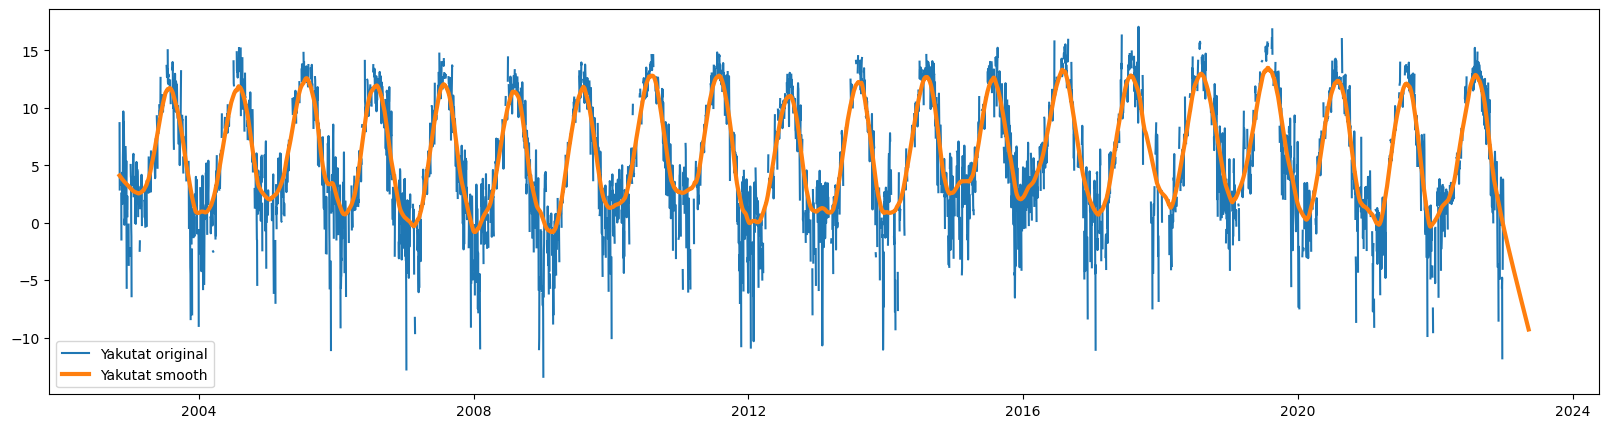

In [49]:
# use lowess filter to smooth temperatue time series, easier on day index rather than datetime format
t0 = pd.Timestamp(dt.datetime.strptime("2017-01-01", "%Y-%m-%d").date())
t_index_data   = np.zeros(len(df_weather.index), dtype=int)
# ddd = [dt.datetime.strptime(d, format).date() for d in df_avyr["Date"]]
for (i, da) in enumerate(df_weather.index):
    deltat = da - t0
    t_index_data[i] = deltat.days
lowess = sm.nonparametric.lowess

# df_smooth = pd.DataFrame({"Date" : df_all.Date})
z = lowess(df_weather["AirTempC_Yakutat"], t_index_data, frac=1/60, xvals=t_index_data)
df_weather["AirTempC_Yakutat_smooth"] = z
# z = lowess(df_weather["AirTempC_Haenke1"], t_index_data, frac=1/60, xvals=t_index_data)
# df_weather["AirTempC_Haenke1_smooth"] = z

plt.figure(figsize=(20,5))
plt.plot(df_weather.index, df_weather["AirTempC_Yakutat"], label="Yakutat original")
plt.plot(df_weather.index, df_weather["AirTempC_Yakutat_smooth"], lw=3, label="Yakutat smooth")
plt.legend()

# plt.figure(figsize=(20,5))
# plt.plot(df_weather.index, df_weather["AirTempC_Haenke1"])
# plt.plot(df_weather.index, df_weather["AirTempC_Haenke1_smooth"], lw=3)

In [50]:
# define function to cut all the time series to the minimal overlap
def equal_period(df_inputs):
    dstart = np.max([np.min(df.index) for df in df_inputs])
    dend   = np.min([np.max(df.index) for df in df_inputs])
    dfs = [df.iloc[np.where((df.index >= dstart) & (df.index <= dend))[0]] for df in df_inputs]
    return dfs

In [295]:
# combine all data together in one dataframe
df_mooring1, df_veloc1, df_terminus1, df_weather1    = equal_period([df_mooring, df_veloc, df_terminus, df_weather])

assert len(df_mooring1) == len(df_veloc1) == len(df_terminus1) == len(df_weather1)

df_all  = pd.DataFrame()
for (df, nam) in zip([df_veloc1, df_terminus1, df_weather1, df_mooring1.iloc[:,0:4]], ["velocity", "terminus", "", ""]):
    if df_all.empty:
        df_all["Date"] = pd.to_datetime(df.index)  # df.index
    if (nam == "velocity") or (nam == "terminus"):
        df_all[nam] = df.mean(axis=1).values
    else:
        df_all = df.merge(df_all, how="inner", on="Date")
df_save = df_all.rename(columns={"terminus":"terminus_advance_m", "velocity":"surface_speed_m_per_yr", "Temperature [deg C] @ 25m":"OceanTemp@25m_degC", "Temperature [deg C] @ 50m":"OceanTemp@50m_degC", "Temperature [deg C] @ 100m":"OceanTemp@100m_degC", "Precip_Yakutat":"Precip_Yakutat_24h_meters"})
df_save.to_csv("terminus_speed_weather_ocean.csv", index=False)
df_all

,Date,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,Temperature [deg C] @ 150m,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,velocity,terminus
0,2017-01-13,5.694918,6.284202,7.014216,6.365307,1.360870,0.706522,3.028502,0.003556,1.360870,0.706522,3.028502,1.130423,2184.476719,311.981900
1,2017-01-14,5.669834,6.247496,6.975026,6.334461,1.673118,0.976344,3.667391,0.069088,1.673118,0.976344,3.667391,1.103321,2194.894241,311.839765
2,2017-01-15,5.643875,6.210486,6.936780,6.303478,1.703297,0.995604,2.999580,0.051054,1.703297,0.995604,2.999580,1.076603,2205.311762,311.697630
3,2017-01-16,5.617070,6.172883,6.899161,6.272173,2.396703,1.710989,3.036864,0.028702,2.396703,1.710989,3.036864,1.050198,2215.729284,311.555496
4,2017-01-17,5.589507,6.134442,6.861821,6.240383,0.417778,-0.348889,-1.948101,0.037084,0.417778,0.000000,0.000000,1.024056,2226.146805,311.413361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,2020-05-07,5.390310,4.851969,5.109256,5.167097,6.113542,5.652083,9.799363,0.001270,6.113542,5.652083,9.799363,6.630535,2264.153415,107.522811
1211,2020-05-08,5.431897,4.870253,5.126338,5.162342,7.092708,6.635417,NaN,NaN,7.092708,6.635417,NaN,6.740607,2271.379046,107.144851
1212,2020-05-09,5.473854,4.888587,5.143451,5.157583,7.800000,7.385417,NaN,NaN,7.800000,7.385417,NaN,6.850573,2278.604677,106.766891
1213,2020-05-10,5.516171,4.906971,5.160596,5.152821,8.436842,8.034737,NaN,NaN,8.436842,8.034737,NaN,6.960391,2285.830309,106.388931


In [296]:
# combine all data together in one dataframe
# df_veloc1, df_terminus1, df_weather1    = equal_period([df_veloc, df_terminus, df_weather])

# assert len(df_veloc1) == len(df_terminus1) == len(df_weather1)

# df_all  = pd.DataFrame()
# for (df, nam) in zip([df_veloc1, df_terminus1, df_weather1], ["velocity", "terminus", "", ""]):
#     if df_all.empty:
#         df_all["Date"] = pd.to_datetime(df.index)  # df.index
#     if (nam == "velocity") or (nam == "terminus"):
#         df_all[nam] = df.mean(axis=1).values
#     else:
#         df_all = df.merge(df_all, how="inner", on="Date")
# df_all
# df_save = df_all.rename(columns={"terminus":"terminus_advance_m", "velocity":"surface_speed_m_per_yr"})
# df_save.to_csv("terminus_speed_weather.csv", index=False)
# df_save

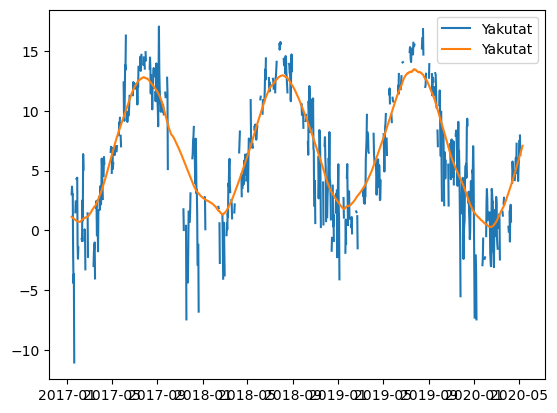

In [297]:
plt.plot(df_all.Date,df_all.AirTempC_Yakutat,label="Yakutat")
plt.plot(df_all.Date,df_all.AirTempC_Yakutat_smooth,label="Yakutat")
# plt.plot(df_all.Date,df_all.AirTempC_Haenke1,label="Haenke1")
# plt.plot(df_all.Date,df_all.AirTempC_Haenke2,label="Haenke2")
plt.legend()

In [298]:
# make sure the end of the time series stops at the day of the year it starts (otherwise there are jumps in computing means over different years if days in e.g. January have less samples than in May)
end_year      = df_all.Date.iloc[-1].year
start_date    = df_all.Date.iloc[77].date()
end_date      = start_date.replace(year=end_year)
id_full_years = np.where((df_all.Date >= pd.Timestamp(start_date)) & (df_all.Date < pd.Timestamp(end_date) - pd.Timedelta(days=1)))               # removing last day as the last year 2020 happens to be a leap day, makes sure there is the same amount of days in all of the years
df_full_years = df_all.iloc[id_full_years[0],:]
df_full_years.reset_index(inplace=True)

# check that there is the same amount of days for each day of the year
tind    =  [di.timetuple().tm_yday for di in df_full_years["Date"] ]
for d in range(np.min(tind), np.max(tind)+1):
    assert np.sum(np.array(tind) == d) == 3

df_full_years

,index,Date,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,Temperature [deg C] @ 150m,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,velocity,terminus
0,77,2017-03-31,4.763858,4.637863,4.822419,5.127810,2.760920,2.151724,3.487537,0.030988,2.760920,2.151724,3.487537,3.023784,2159.858116,189.793988
1,78,2017-04-01,4.779301,4.642731,4.810840,5.134597,2.995556,2.367778,3.728571,0.048514,2.995556,2.367778,3.728571,3.109240,2160.072172,187.818402
2,79,2017-04-02,4.794743,4.647599,4.799261,5.141384,1.734091,1.088636,2.167516,0.019812,1.734091,1.088636,2.167516,3.196495,2160.286228,185.842817
3,80,2017-04-03,4.810186,4.652467,4.787682,5.148170,2.165934,1.560440,3.167846,0.003556,2.165934,1.560440,3.167846,3.297332,2160.500283,183.867232
4,81,2017-04-04,4.825628,4.657335,4.776102,5.154957,4.820000,4.293333,6.005387,0.013716,4.820000,4.293333,6.005387,3.376169,2162.387356,182.683368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,1167,2020-03-25,4.181499,4.227955,4.609210,5.357222,0.830208,0.290625,NaN,NaN,0.830208,0.290625,NaN,2.331668,2002.130683,125.119077
1091,1168,2020-03-26,4.184868,4.230789,4.606020,5.353590,2.015625,1.429167,1.757098,0.000254,2.015625,1.429167,1.757098,2.414626,1995.845869,124.286676
1092,1169,2020-03-27,4.188803,4.234595,4.604397,5.349918,1.568750,1.075000,NaN,NaN,1.568750,1.075000,NaN,2.499003,1989.561054,123.454276
1093,1170,2020-03-28,4.193424,4.239412,4.604203,5.346199,-2.887500,-3.428125,NaN,NaN,0.000000,0.000000,NaN,2.565503,1983.276240,122.621876


In [299]:
def unique(x):
    return list(set(x))

# average over the year
ti_start_date = start_date.timetuple().tm_yday -1
strt_date = dt.date(start_date.year, 1, 1)
df_avyr = pd.DataFrame()
for col in df_full_years:
    if col == "Date":
        continue
    vls = []
    for dd in range(np.min(tind), np.max(tind)+1):
        val = np.mean(df_full_years[col][np.where(np.array(tind) == dd)[0]])
        vls.append(val)
    if df_avyr.empty:
        ds = []
        for doy in np.sort(unique(tind)):
            if doy <= ti_start_date:
                ds.append(strt_date.replace(year=strt_date.year+1)  + dt.timedelta(days=int(doy) - 1))
            else:
                ds.append(strt_date + dt.timedelta(days=int(doy) - 1))
        df_avyr["Date"] = ds
    df_avyr[col] = vls
df_avyr.sort_values(by="Date", inplace=True)
df_avyr.Date = pd.to_datetime(df_avyr.Date)   # otherwise Date is not in the correct format for .resample
df_avyr

,Date,index,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,Temperature [deg C] @ 150m,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,velocity,terminus
89,2017-03-31,442.0,5.009595,5.059443,5.347910,5.591049,3.369288,2.817486,3.487537,0.030988,3.369288,2.817486,3.487537,3.785850,2149.486822,146.364869
90,2017-04-01,443.0,5.031009,5.071076,5.341222,5.594856,2.972950,2.427114,3.728571,0.048514,2.972950,2.427114,3.728571,3.867465,2153.365347,145.248507
91,2017-04-02,444.0,5.052439,5.082591,5.335438,5.598936,3.537768,2.993465,2.167516,0.019812,3.537768,2.993465,2.167516,3.952120,2157.243872,144.132144
92,2017-04-03,445.0,5.073831,5.093947,5.330459,5.603269,2.017164,1.478071,3.167846,0.003556,2.017164,1.478071,3.167846,4.039761,2161.122397,143.015781
93,2017-04-04,446.0,5.095133,5.105113,5.326161,5.607836,2.526577,1.983423,6.005387,0.013716,2.904236,2.555764,6.005387,4.118921,2166.362986,142.258163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2018-03-26,802.0,4.735720,4.872733,5.306372,5.664446,1.221652,0.657839,NaN,NaN,1.613227,1.251612,NaN,3.301292,2083.928270,127.164504
85,2018-03-27,803.0,4.752497,4.883522,5.297322,5.663201,2.388956,1.796841,1.627285,0.001524,2.497917,2.131250,1.627285,3.380348,2083.622797,126.406281
86,2018-03-28,804.0,4.769630,4.894765,5.289808,5.662272,2.048541,1.467470,2.176543,0.006096,2.048541,1.467470,2.176543,3.456940,2083.317324,125.648057
87,2018-03-29,805.0,4.787143,4.906437,5.283831,5.661653,0.305979,-0.242464,NaN,NaN,1.268479,0.900244,NaN,3.528304,2083.011850,124.889834


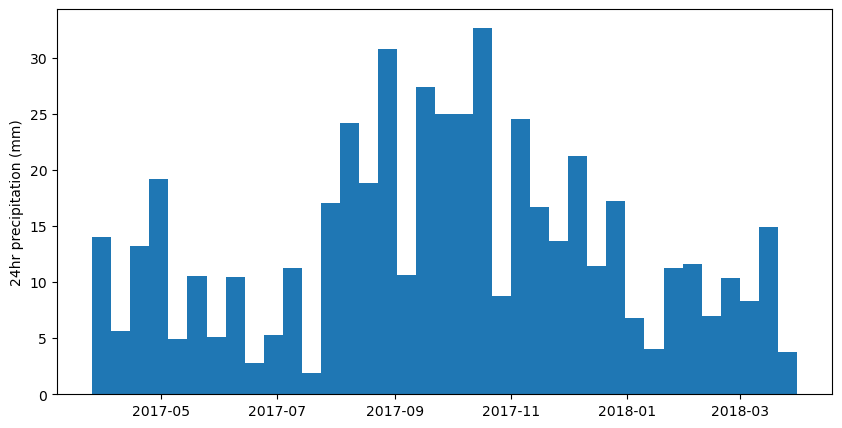

In [300]:
# resample precipitation data
dt_resample = 10
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
df_sum = df_avyr.resample(str(dt_resample)+"d", on="Date").mean().interpolate()
ax.bar(df_sum.index, df_sum.Precip_Yakutat*1000, width=dt.timedelta(days=dt_resample), linewidth=0)
ax.set_ylabel("24hr precipitation (mm)")
ax.xaxis_date()

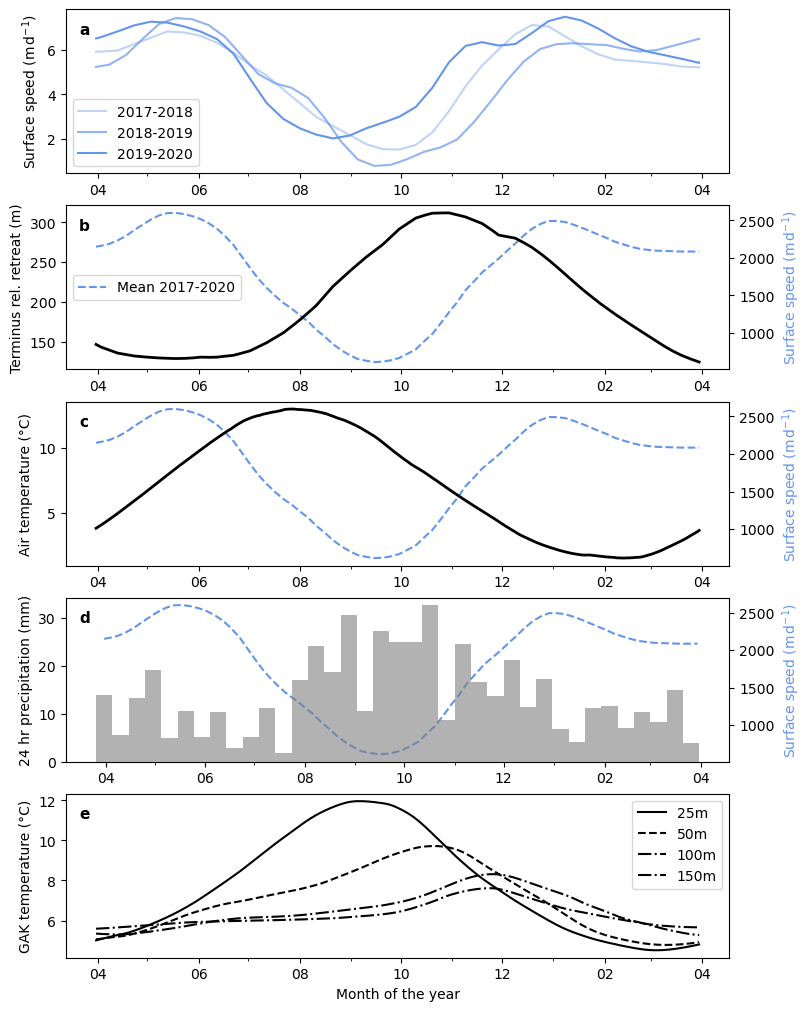

In [301]:
def format_ax(ax, panel, plot_vel=True, draw_legend=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2,4,6,8,10,12]))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    if plot_vel:
        secax = ax.twinx()
        secax.plot(df_avyr["Date"], df_avyr["velocity"], color="cornflowerblue", linestyle="--", label="Mean 2017-2020")
        secax.set_ylabel(r"Surface speed ($\mathrm{m\,d^{-1}}$)", color="cornflowerblue")
        ax.set_zorder(secax.get_zorder()+1)
        ax.set_frame_on(False)                      # see https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
        if draw_legend:
            secax.legend(loc="center left")
    ax.annotate(panel, (0.02,0.85), xycoords='axes fraction', fontweight='bold', fontsize=11)

# can replace df_avyr by df_all to only average over sections and not year
fig, ax = plt.subplots(5,1, layout='constrained', figsize=(8,10))

# velocity
i = 0
alphas = [0.4, 0.7, 1.0]
for ii in range(1, 4):
    yr0 = pd.Timestamp(start_date) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_full_years.Date >= yr0) & (df_full_years.Date < pd.Timestamp(start_date) + pd.Timedelta(days=365*ii)))[0]
    ax[i].plot(df_avyr.Date, df_full_years["velocity"][id_yr] / 365, color="cornflowerblue", alpha=alphas[ii-1], label=str(yr0.year)+"-"+str(yr0.year+1))
    ax[i].set_ylabel(r"Surface speed ($\mathrm{m\,d^{-1}}$)")
    ax[i].legend()
format_ax(ax[i], "a", plot_vel=False)

# Terminus position
i = 1
ax[i].plot(df_avyr["Date"], df_avyr.terminus, color="black", lw=2); ax[i].set_ylabel("Terminus rel. retreat (m)")
format_ax(ax[i], "b", draw_legend=True)

# Air temperature
i = 2
ax[i].plot(df_avyr["Date"], df_avyr.AirTempC_Yakutat_smooth, color="black", lw=2); ax[i].set_ylabel("Air temperature (°C)")
format_ax(ax[i], "c")

# Precipitation
i = 3
ax[i].bar(df_sum.index, df_sum.Precip_Yakutat *1000, width=dt.timedelta(days=dt_resample), color="grey", alpha=0.6, linewidth=0); ax[i].set_ylabel("24 hr precipitation (mm)")
format_ax(ax[i], "d")

# GAK temperatures
i = -1
stls = ["-", "--", "-.", "-.", "."]
for (n,col) in enumerate(df_all.filter(like="Temperature [deg C] @", axis=1)):
    ax[i].plot(df_avyr["Date"], df_avyr[col], stls[n], label=col.split(" ")[-1], color="black"); ax[i].set_ylabel("GAK temperature (°C)")
    ax[i].legend()
    ax[i].set_xlabel("Month of the year")
format_ax(ax[i], "e", False)

fig.savefig("four-panel-yearly.jpg")

Text(0.1, 0.9, 'b')

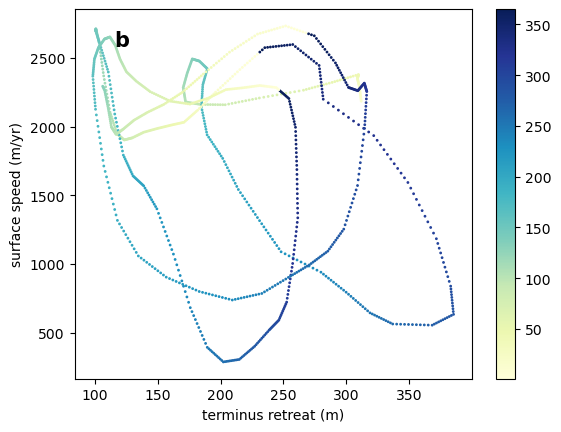

In [302]:
d_ofyear    =  [di.timetuple().tm_yday for di in df_all["Date"] ]   # day of the year
plt.scatter(df_all.terminus, df_all.velocity, 1, d_ofyear, cmap="YlGnBu")
plt.xlabel("terminus retreat (m)")
plt.ylabel("surface speed (m/yr)")
plt.colorbar()
plt.annotate("b", (0.1,0.9), xycoords='axes fraction', fontweight='bold', fontsize=15)

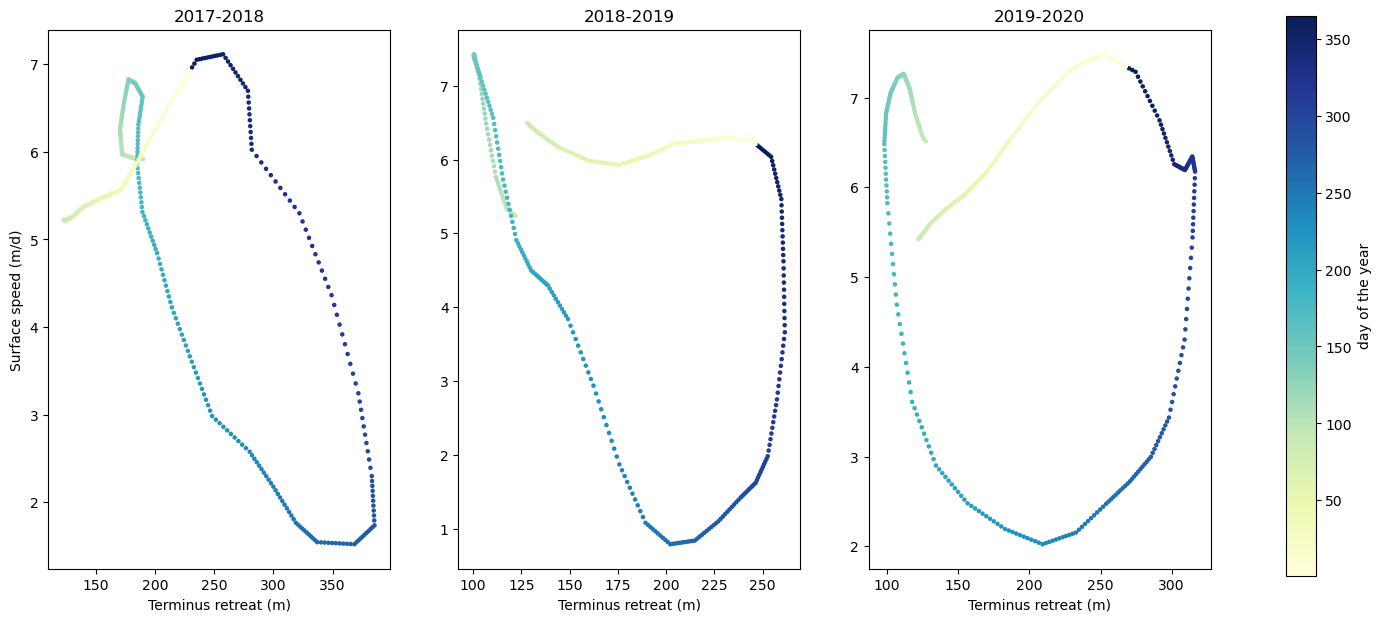

In [303]:
fig, ax = plt.subplots(1,3, figsize=(15,7)) #, sharex=True, sharey=True)
cax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
d_ofyear    =  np.array([di.timetuple().tm_yday for di in df_full_years["Date"] ])   # day of the year
for ii in range(1, 4):
    yr0 = pd.Timestamp(start_date) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_full_years.Date >= yr0) & (df_full_years.Date < pd.Timestamp(start_date) + pd.Timedelta(days=365*ii)))[0]
    im = ax[ii-1].scatter(df_full_years.terminus[id_yr], df_full_years["velocity"][id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
    ax[ii-1].set_xlabel("Terminus retreat (m)")
    ax[ii-1].set_title(str(yr0.year)+"-"+str(yr0.year+1))
ax[0].set_ylabel("Surface speed (m/d)")
fig.colorbar(im, cax=cax, orientation='vertical',label="day of the year")

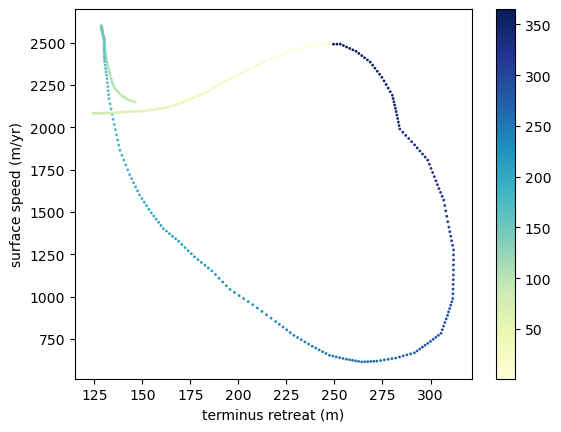

In [304]:
d_ofyear    =  [di.timetuple().tm_yday for di in df_avyr["Date"] ]   # day of the year
plt.scatter(df_avyr.terminus, df_avyr.velocity, 1, d_ofyear, cmap="YlGnBu") # cmap="twilight"
plt.xlabel("terminus retreat (m)")
plt.ylabel("surface speed (m/yr)")
plt.colorbar()

/tmp/ipykernel_87719/2047856609.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_weather0.PDD_Haenke1[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_87719/2047856609.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_weather0.PDD_Haenke1[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_87719/2047856609.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

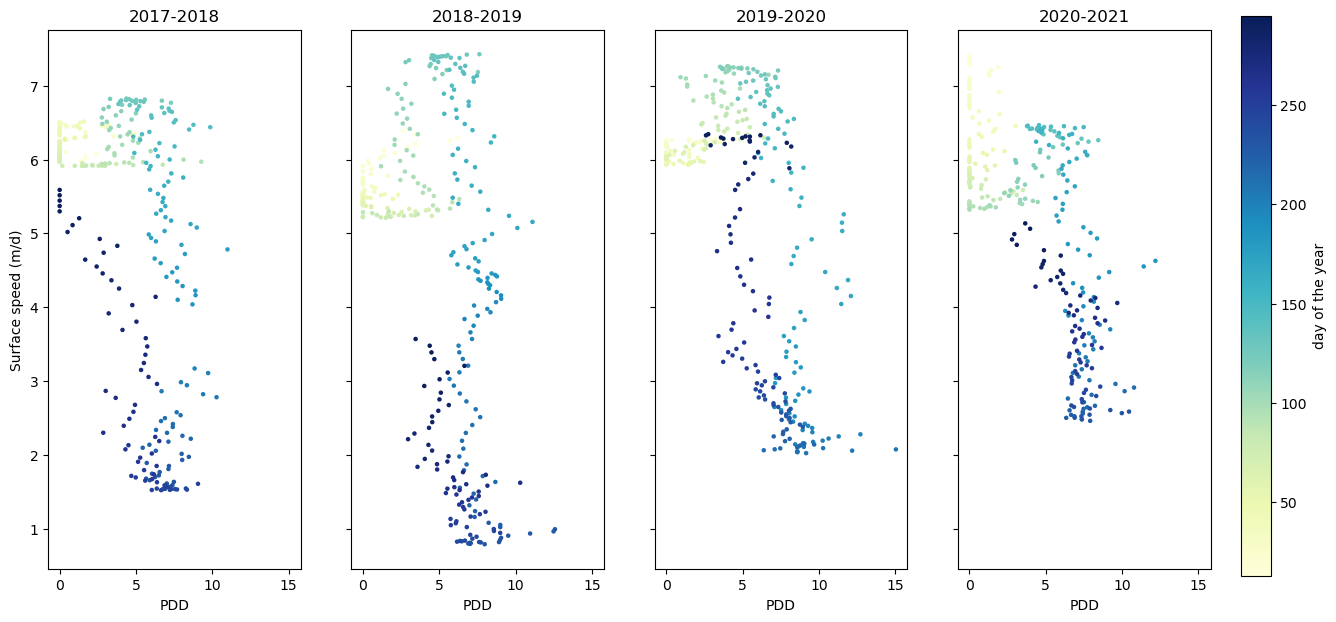

In [305]:
# scatter plot PDD vs velocity
df_veloc0, df_weather0 = equal_period([df_veloc,df_weather])
# df_veloc0 = df_veloc0.resample("2d").mean().interpolate()
# df_weather0 = df_weather0.resample("2d").mean().interpolate()
start_date0    = df_veloc0.index[0].date()

df_weather0
dt_overlap = -50

fig, ax = plt.subplots(1,4, figsize=(15,7), sharex=True, sharey=True)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
d_ofyear    =  np.array([di.timetuple().tm_yday for di in df_veloc0.index ])   # day of the year
for ii in range(1, 5):
    yr0 = pd.Timestamp(start_date0) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_veloc0.index >= yr0) & (df_veloc0.index < pd.Timestamp(start_date0) + pd.Timedelta(days=365*ii+dt_overlap)))[0]
    im = ax[ii-1].scatter(df_weather0.PDD_Haenke1[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
    ax[ii-1].set_xlabel("PDD")
    ax[ii-1].set_title(str(yr0.year)+"-"+str(yr0.year+1))
ax[0].set_ylabel("Surface speed (m/d)")
fig.colorbar(im, cax=cax, orientation='vertical',label="day of the year")
# fig.savefig("veloc_cumPDD_scatter.jpg")
fig.savefig("veloc_PDD_scatter.jpg")

/tmp/ipykernel_87719/1949334714.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_terminus0.mean(axis=1)[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_87719/1949334714.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_terminus0.mean(axis=1)[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_87719/1949334714.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

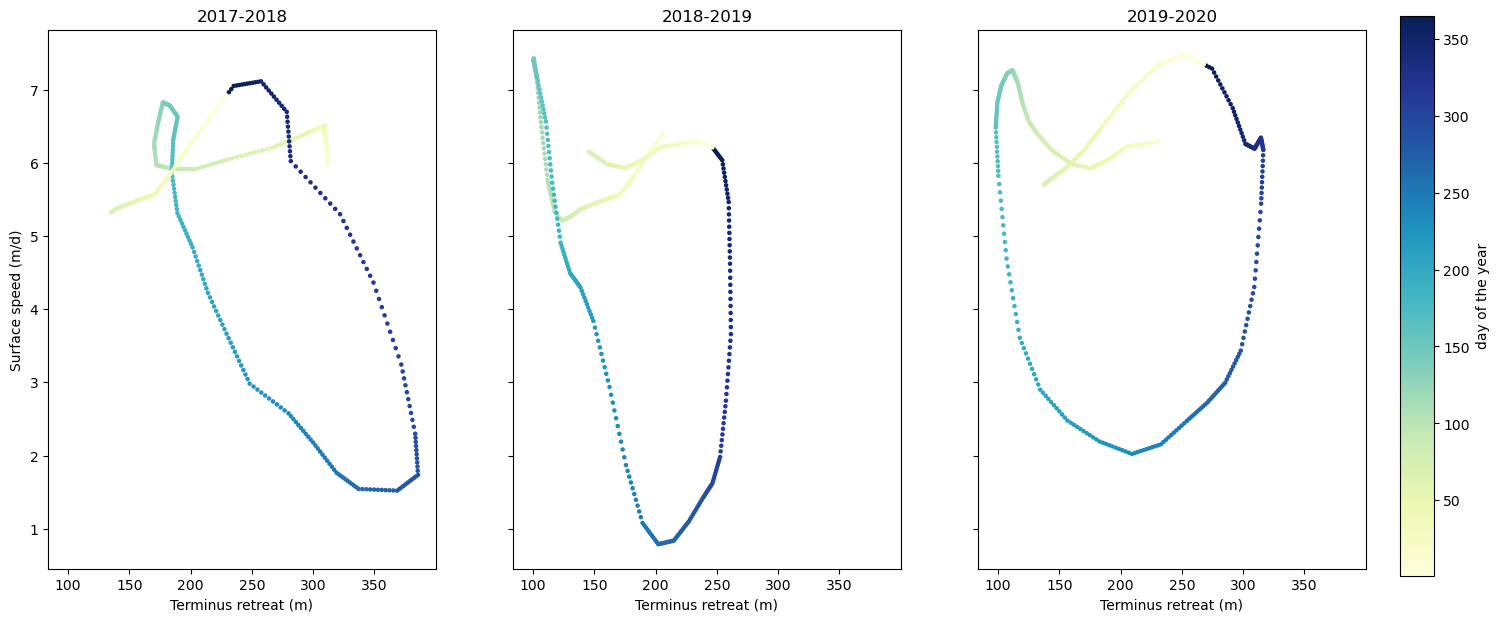

In [294]:
# scatter plot terminus vs velocity
df_veloc0, df_terminus0 = equal_period([df_veloc,df_terminus])
start_date0    = df_veloc0.index[0].date()

dt_overlap = 60

fig, ax = plt.subplots(1,3, figsize=(17,7), sharex=True, sharey=True)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
d_ofyear    =  np.array([di.timetuple().tm_yday for di in df_veloc0.index ])   # day of the year
for ii in range(1, 4):
    yr0 = pd.Timestamp(start_date0) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_veloc0.index >= yr0) & (df_veloc0.index < pd.Timestamp(start_date0) + pd.Timedelta(days=365*ii+dt_overlap)))[0]
    im = ax[ii-1].scatter(df_terminus0.mean(axis=1)[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
    ax[ii-1].set_xlabel("Terminus retreat (m)")
    ax[ii-1].set_title(str(yr0.year)+"-"+str(yr0.year+1))
ax[0].set_ylabel("Surface speed (m/d)")
fig.colorbar(im, cax=cax, orientation='vertical',label="day of the year")
fig.savefig("veloc_terminus_scatter.jpg")